<a href="https://colab.research.google.com/github/geniusserg/DataAnalyzis/blob/main/vk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!wget https://cups.online/api_v2/task/1417/177


--2022-12-04 20:27:42--  https://cups.online/api_v2/task/1417/177
Resolving cups.online (cups.online)... 188.93.56.95
Connecting to cups.online (cups.online)|188.93.56.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27995145 (27M) [text/csv]
Saving to: ‘177’

177                 100%[===================>]  26.70M  10.4MB/s    in 2.6s    

2022-12-04 20:27:46 (10.4 MB/s) - ‘177’ saved [27995145/27995145]



Отобразим датасет

In [34]:
df = pd.read_csv("177")[["text", "category"]]
df

,text,category
0,Волшебные фото Виктория Поплавская ЕвгенияМедв...,winter_sport
1,Возвращение в подземелье Треша 33 Эйфория тупо...,extreme
2,Лучшие чешские вратари – Доминик Доминатор Гаш...,football
3,Rtokenoid Warhammer40k валрак решил нас подкор...,boardgames
4,Шестеркин затаскивает Рейнджерс в финал Восточ...,hockey
...,...,...
38735,8 битная буря снова накрыла пикселями автомоби...,autosport
38736,Ира Сидоркова объясняет как сказалась на ее ма...,autosport
38737,24 я ракетка мира хорват Марин Чилич обыграл и...,tennis
38738,Стал известен календарь мужской сборной России...,volleyball


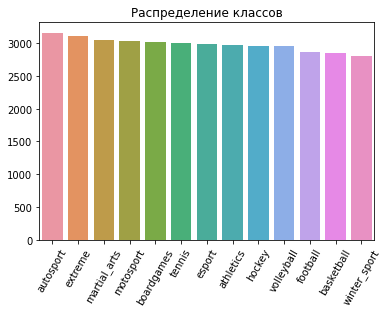

In [35]:
vcdf = df["category"].value_counts()
bplot = sns.barplot(x=vcdf.keys(), y=vcdf.values)
_, labels = plt.xticks()
plt.setp(labels, rotation=60)
plt.title("Распределение классов")
plt.show()
categories = vcdf.keys()

Пример текста

In [5]:
df.loc[1245, "text"]

'За кроссовками в Баскетбольный магазин Ghetto Basket Shop Консультация tokenoidtokenoid Стрельский'

Выделим таргеты - классы в отдельную колонку

In [42]:
cats = df["category"].factorize()[1]

In [6]:
df["category_id"] = df["category"].factorize()[0]
df = df.drop(["category"], axis=1)

### TF-IDF

Используем частотный анализатор. Отсечем часть так как весь словарь занимает много места

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
tfdf = TfidfVectorizer(sublinear_tf=True, min_df=5, 
                        ngram_range=(1, 2), stop_words=russian_stopwords)
features = tfdf.fit_transform(df.text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Разделим датасет на тест и трейн части

In [30]:
import numpy as np
t = 7000
X = features[:t].toarray().astype(np.float16)
y = df.category_id[:t]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

Проведем 5 кросс валидацию на 4 моделях

In [ ]:

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
entries = []
for clf in models:
    model_name = clf.__class__.__name__
    accuracy = cross_val_score(clf, X, y, cv=5)
    for fold_idx, acc_score in enumerate(accuracy):
        entries.append((model_name, fold_idx, acc_score))
cv_df = pd.DataFrame(entries, columns=["model_name", "Fold N", "accuracy"])
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

Получаем точность модели - 0.796

In [31]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.796

In [32]:
!wget https://cups.online/api_v2/task/1417/178 -O test.csv


--2022-12-04 20:32:44--  https://cups.online/api_v2/task/1417/178
Resolving cups.online (cups.online)... 188.93.56.95
Connecting to cups.online (cups.online)|188.93.56.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18933519 (18M) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>]  18.06M  9.62MB/s    in 1.9s    

2022-12-04 20:32:47 (9.62 MB/s) - ‘test.csv’ saved [18933519/18933519]



Применим модель к тестовым данным

In [53]:
df_test = pd.read_csv("test.csv")
tfidf_vectorizer_vectors = tfdf.transform(df_test.text)
y_pred = clf.predict(tfidf_vectorizer_vectors)
res = []
for i in range(len(y_pred)):
  oid = df_test.loc[i, "oid"]
  res.append((oid, cats[y_pred[i]]))
df_result = pd.DataFrame(res, index = None, columns=["oid", "category"])
df_result.to_csv("test_result.csv", index=False)